In [1]:
import pandas as pd
from pyspark.sql import SparkSession

Se importa librería pandas para realizar el ejercicio

In [2]:
spark = SparkSession.builder.appName('BANK').getOrCreate()

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/02/27 20:42:10 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


Se realiza la misma conversión que en el ejercicio 3 para el documento .csv. Se toma solamente la hoja south german credit pues es la única que posee los datos necesarios para trabajar (el resto explica lo que es cada columna)

In [3]:
def createDataFramefromCSV(csv_path):
    dataset = spark.read.options(header='True', delimiter=',', inferSchema= True) \
              .csv(csv_path)
    dataset.printSchema()
    return dataset

In [4]:
dataset = createDataFramefromCSV("./data/south_german_credit.csv")

root
 |-- status: integer (nullable = true)
 |-- duration: integer (nullable = true)
 |-- credit_history: integer (nullable = true)
 |-- purpose: integer (nullable = true)
 |-- amount: integer (nullable = true)
 |-- savings: integer (nullable = true)
 |-- employment_duration: integer (nullable = true)
 |-- installment_rate: integer (nullable = true)
 |-- personal_status_sex: integer (nullable = true)
 |-- other_debtors: integer (nullable = true)
 |-- present_residence: integer (nullable = true)
 |-- property: integer (nullable = true)
 |-- age: integer (nullable = true)
 |-- other_installment_plans: integer (nullable = true)
 |-- housing: integer (nullable = true)
 |-- number_credits: integer (nullable = true)
 |-- job: integer (nullable = true)
 |-- people_liable: integer (nullable = true)
 |-- telephone: integer (nullable = true)
 |-- foreign_worker: integer (nullable = true)
 |-- credit_risk: integer (nullable = true)



dado que se identifican que pueden existir columnas con valores nulos (de lo que arroja el resultado anterior), se debe de eliminar los datos nulos a través de na.drop

In [7]:
dataset = dataset.na.drop()

In [5]:
dataset.columns

['status',
 'duration',
 'credit_history',
 'purpose',
 'amount',
 'savings',
 'employment_duration',
 'installment_rate',
 'personal_status_sex',
 'other_debtors',
 'present_residence',
 'property',
 'age',
 'other_installment_plans',
 'housing',
 'number_credits',
 'job',
 'people_liable',
 'telephone',
 'foreign_worker',
 'credit_risk']

Se vectoriza la tabla y se combina con la actual, mostrando las primeras 2 columnas. Esto, para normalizar los datos
el vector resultado se agrupa en la columna feature

In [7]:
from pyspark.ml.feature import VectorAssembler

In [8]:
assemble = VectorAssembler(inputCols=['status',
 'duration',
 'credit_history',
 'purpose',
 'amount',
 'savings',
 'employment_duration',
 'installment_rate',
 'personal_status_sex',
 'other_debtors',
 'present_residence',
 'property',
 'age',
 'other_installment_plans',
 'housing',
 'number_credits',
 'job',
 'people_liable',
 'telephone',
 'foreign_worker',
 'credit_risk'], outputCol='features')

In [9]:
assembled_data = assemble.transform(dataset)

In [40]:
assembled_data.show(2)

+------+--------+--------------+-------+------+-------+-------------------+----------------+-------------------+-------------+-----------------+--------+---+-----------------------+-------+--------------+---+-------------+---------+--------------+-----------+--------------------+
|status|duration|credit_history|purpose|amount|savings|employment_duration|installment_rate|personal_status_sex|other_debtors|present_residence|property|age|other_installment_plans|housing|number_credits|job|people_liable|telephone|foreign_worker|credit_risk|            features|
+------+--------+--------------+-------+------+-------+-------------------+----------------+-------------------+-------------+-----------------+--------+---+-----------------------+-------+--------------+---+-------------+---------+--------------+-----------+--------------------+
|     1|      18|             4|      2|  1049|      1|                  2|               4|                  2|            1|                4|       2| 21|

Para una mejor organización y análisis, se normalizan los datos y se une con el vector "features" creado en el paso anterior

In [11]:
from pyspark.ml.feature import StandardScaler

In [12]:
scale=StandardScaler(inputCol='features',outputCol='standardized')

In [13]:
data_scale=scale.fit(assembled_data)

In [14]:
data_scale_output=data_scale.transform(assembled_data)

se muestran las primeras 2 columnas de datos donde se muestra las columnas originales (status, duration, etc), más los datos vectorizados y normalizados

In [15]:
data_scale_output.show(2)

+------+--------+--------------+-------+------+-------+-------------------+----------------+-------------------+-------------+-----------------+--------+---+-----------------------+-------+--------------+---+-------------+---------+--------------+-----------+--------------------+--------------------+
|status|duration|credit_history|purpose|amount|savings|employment_duration|installment_rate|personal_status_sex|other_debtors|present_residence|property|age|other_installment_plans|housing|number_credits|job|people_liable|telephone|foreign_worker|credit_risk|            features|        standardized|
+------+--------+--------------+-------+------+-------+-------------------+----------------+-------------------+-------------+-----------------+--------+---+-----------------------+-------+--------------+---+-------------+---------+--------------+-----------+--------------------+--------------------+
|     1|      18|             4|      2|  1049|      1|                  2|               4|  

Sin datos nulos y con la información normalizada, se puede avanzar en la generación de kmeans y cluster, incorporando las librerías en python
se define determinar el esfuerzo asociado para los primeros 100 cluster. 
Para los 100 primeros cluster se utiliza la métrica de silhouette

In [31]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
silhouette_score=[]
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')
for i in range(2,100):
    KMeans_algo=KMeans(featuresCol='standardized', k=i)
    KMeans_fit=KMeans_algo.fit(data_scale_output)
    output=KMeans_fit.transform(data_scale_output)
    score=evaluator.evaluate(output)
    silhouette_score.append(score)

Se grafica el esfuerzo (eje y) en función del número de cluster (eje x)

Text(0, 0.5, 'cost')

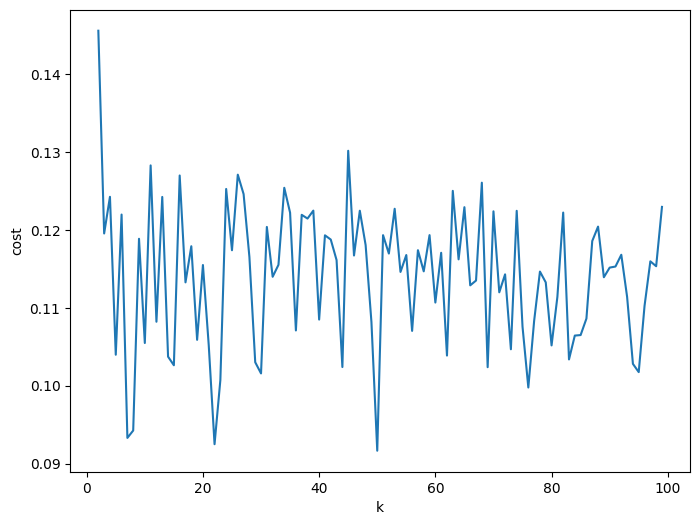

In [32]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,1, figsize =(8,6))
ax.plot(range(2,100),silhouette_score)
ax.set_xlabel("k")
ax.set_ylabel("cost")

Se realiza zoom para los primeros 14, pues de la gráfica anterior se puede apreciar que para los siguientes se ve un comportamiento similar. 
Del gráfico, se puede apreciar que el óptimo (respecto a costos) es segmentar a los clientes en 7 tipos

Text(0, 0.5, 'cost')

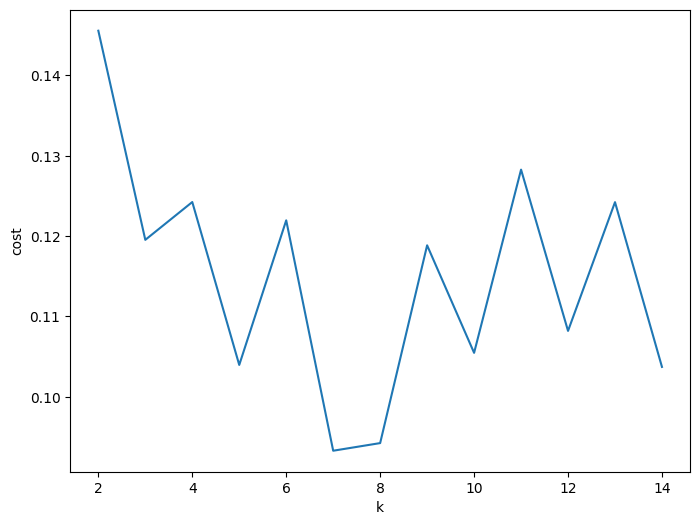

In [41]:
ax.set_ylabel("cost")
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1, 1, figsize=(8, 6))
ax.plot(range(2, 15), silhouette_score[0:13])
ax.set_xlabel("k")
ax.set_ylabel("cost")

In [39]:
silhouette_score[0:13]

[0.14555585485891193,
 0.1195312665514915,
 0.12423622323310107,
 0.10396497087759186,
 0.12195848217662425,
 0.0932889748706788,
 0.09423858044054659,
 0.11885002172911134,
 0.10546998339654637,
 0.12826924099396023,
 0.10820090254597804,
 0.1242214713508559,
 0.10371849855977835]

In [29]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
K = 4
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='standardized', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

KMeans_algo=KMeans(featuresCol='standardized', k=K)
KMeans_fit=KMeans_algo.fit(data_scale_output)
output=KMeans_fit.transform(data_scale_output)


In [30]:
from pyspark.ml.feature import PCA
pca = PCA(k=2, inputCol="features", outputCol="pca")
pca_model = pca.fit(output)

In [31]:
pca_transformed = pca_model.transform(assembled_data)

In [32]:
import numpy as np
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())

In [33]:
cluster_assignment = np.array(output.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)

In [34]:
pca_data = np.hstack((x_pca,cluster_assignment))

In [35]:
pca_data

array([[1.04904710e+03, 1.79193846e+01, 0.00000000e+00],
       [2.79901867e+03, 3.49419772e+01, 1.00000000e+00],
       [8.41032642e+02, 2.09080303e+01, 0.00000000e+00],
       ...,
       [1.26800149e+04, 3.06468366e+01, 3.00000000e+00],
       [6.46801645e+03, 5.13787357e+01, 3.00000000e+00],
       [6.35006162e+03, 2.75575056e+01, 2.00000000e+00]])

In [36]:
pca_df = pd.DataFrame(data=pca_data, columns=("X", "Y","cluster_assignment"))

In [37]:
pca_df

,X,Y,cluster_assignment
0,1049.047100,17.919385,0.0
1,2799.018672,34.941977,1.0
2,841.032642,20.908030,0.0
3,2122.029328,37.086909,1.0
4,2171.029110,36.190698,1.0
...,...,...,...
995,1987.059915,17.135242,0.0
996,2303.061523,40.818065,0.0
997,12680.014850,30.646837,3.0
998,6468.016449,51.378736,3.0


Para los 7 cluster, se realiza el gráfico de dispersión que permite mostrar visualmente cómo quedan segmentados los clientes

In [57]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator
K = 7
evaluator = ClusteringEvaluator(predictionCol='prediction', featuresCol='features', \
                                metricName='silhouette', distanceMeasure='squaredEuclidean')

KMeans_algo=KMeans(featuresCol='features', k=K)
KMeans_fit=KMeans_algo.fit(assembled_data)
output=KMeans_fit.transform(assembled_data)

In [58]:
from pyspark.ml.feature import PCA
pca = PCA(k=2, inputCol="features", outputCol="pca")
pca_model = pca.fit(output)
pca_transformed = pca_model.transform(assembled_data)
import numpy as np
x_pca = np.array(pca_transformed.rdd.map(lambda row: row.pca).collect())
cluster_assignment = np.array(output.rdd.map(lambda row: row.prediction).collect()).reshape(-1,1)
pca_data = np.hstack((x_pca,cluster_assignment))
pca_df = pd.DataFrame(data=pca_data, columns=("X", "Y","cluster_assignment"))


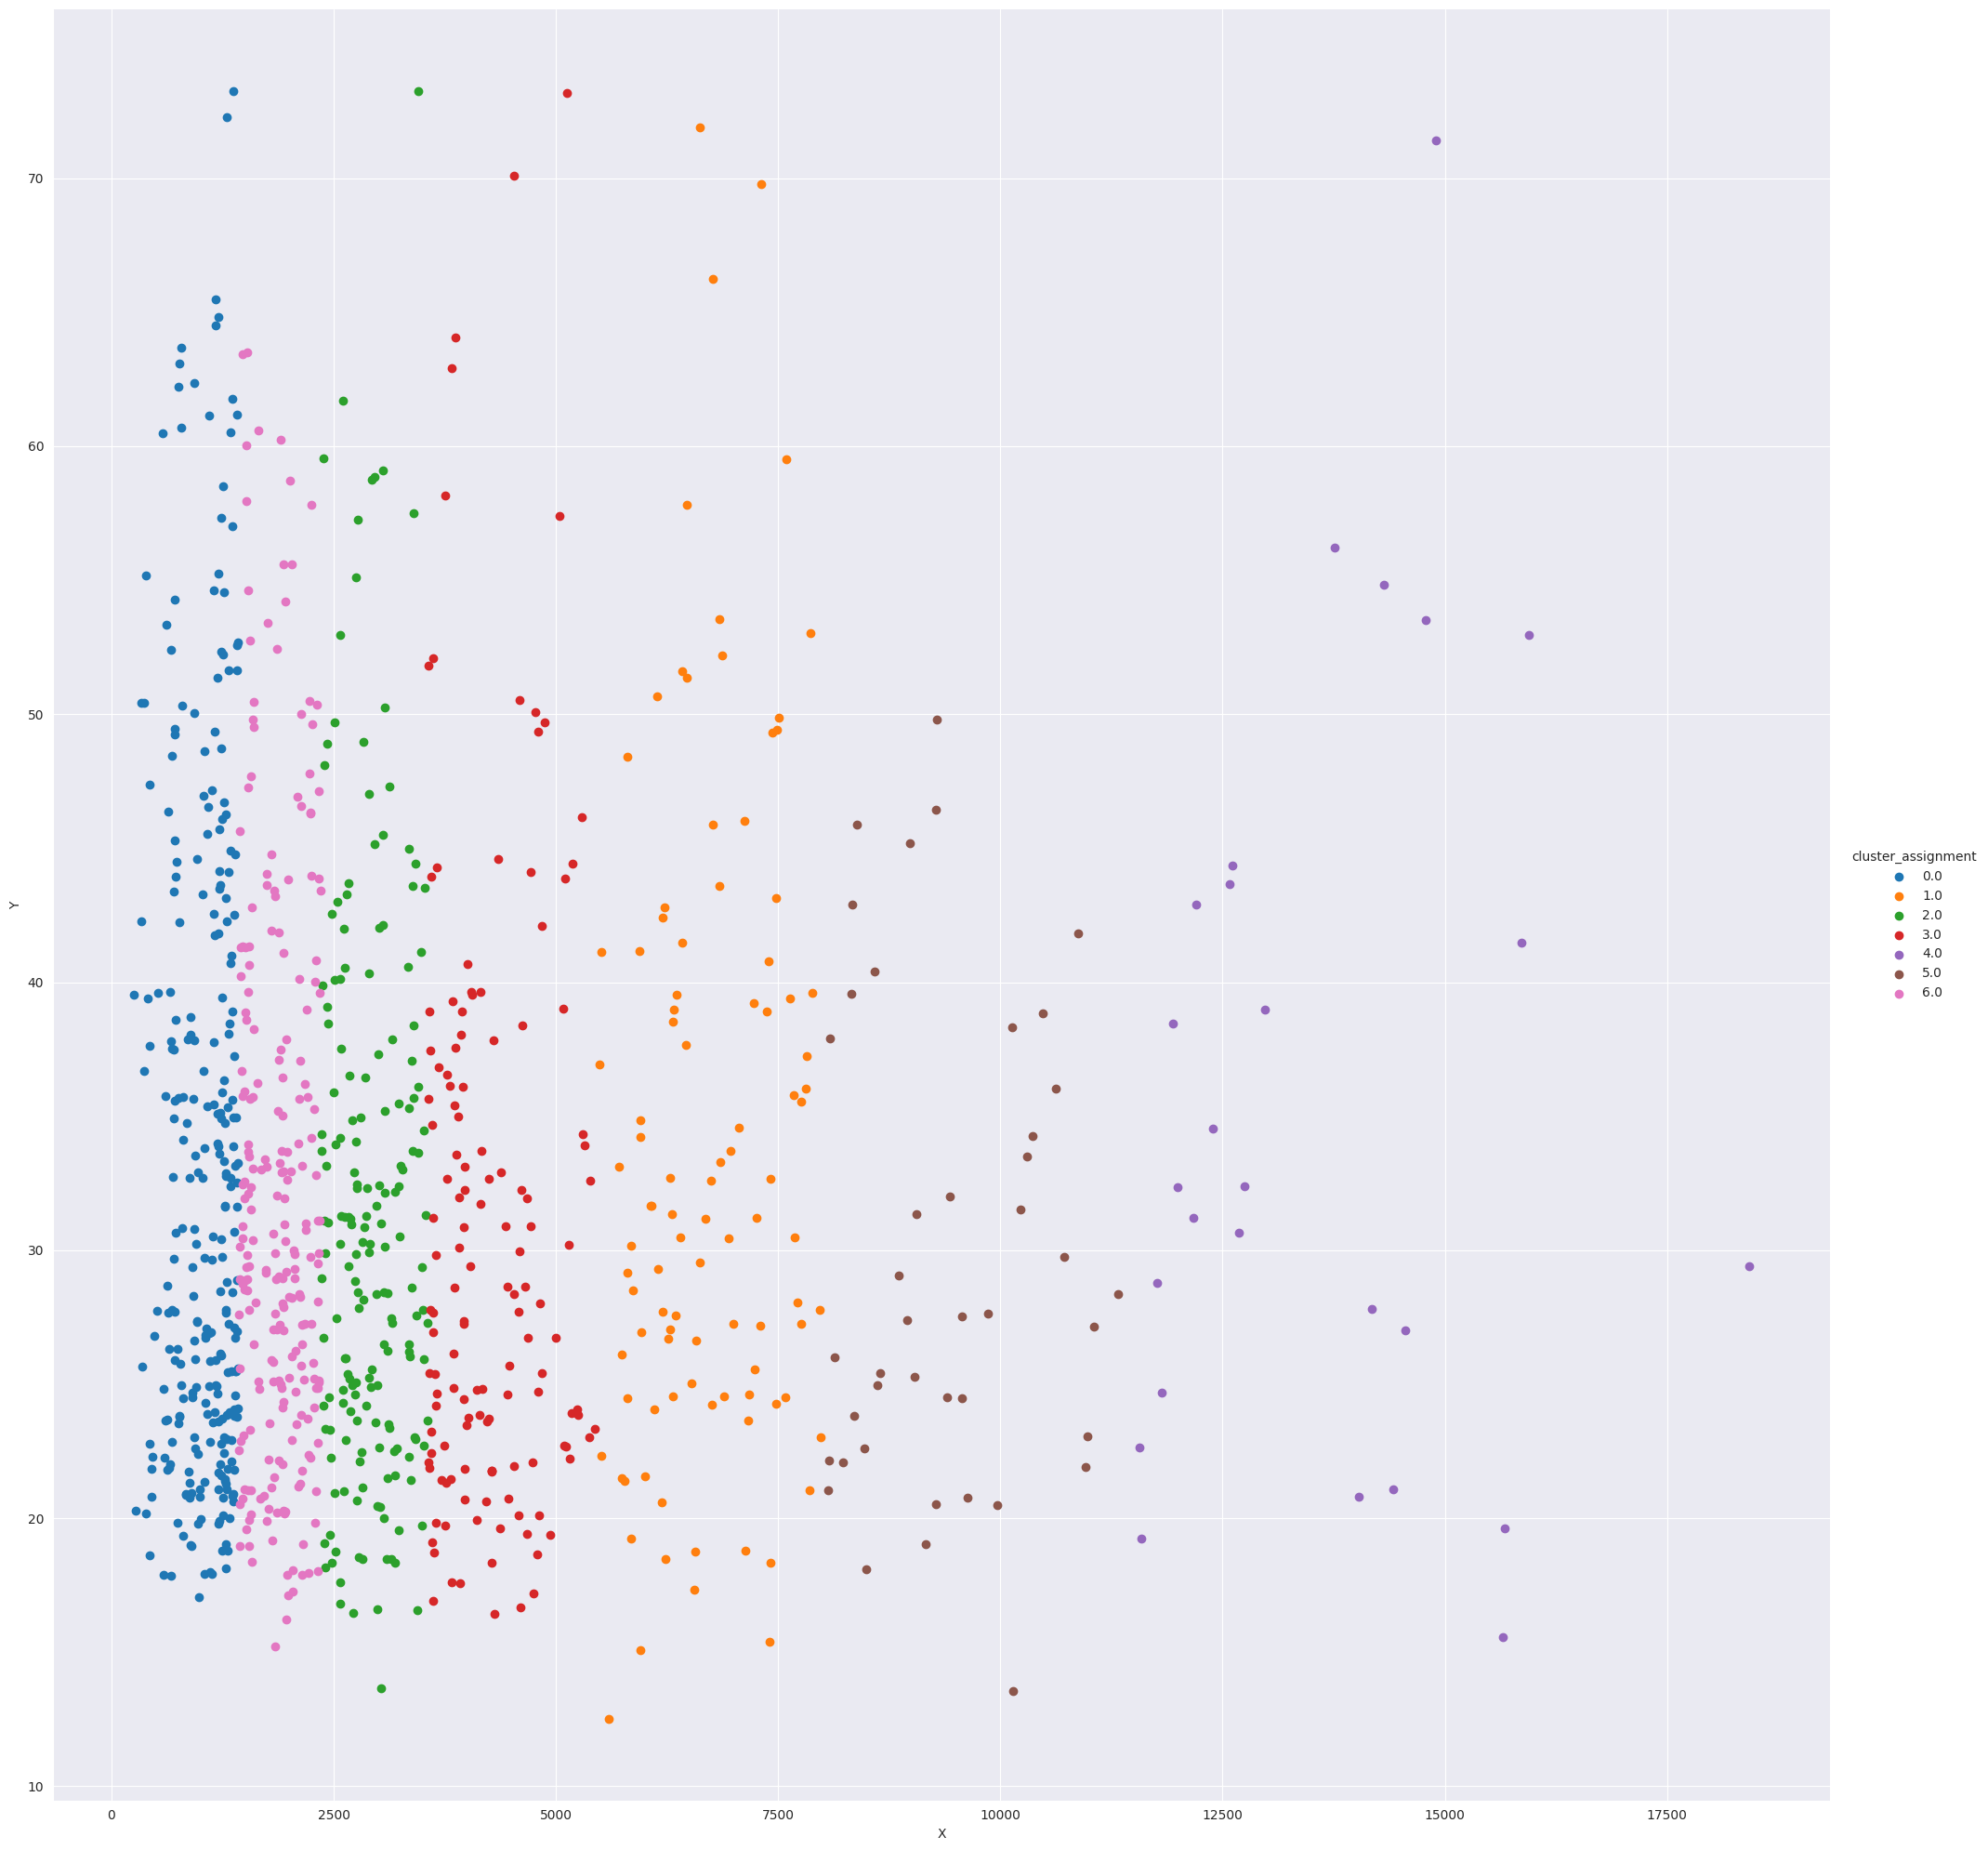

In [59]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.FacetGrid(pca_df,hue="cluster_assignment", height=20).map(plt.scatter, 'X', 'Y' ).add_legend()
plt.show()

In [72]:
pca_df

,X,Y,cluster_assignment
0,1049.047100,17.919385,0.0
1,2799.018672,34.941977,2.0
2,841.032642,20.908030,0.0
3,2122.029328,37.086909,6.0
4,2171.029110,36.190698,6.0
...,...,...,...
995,1987.059915,17.135242,6.0
996,2303.061523,40.818065,6.0
997,12680.014850,30.646837,4.0
998,6468.016449,51.378736,1.0


se genera documento de salida con esta información, donde se realizará la parte c y d del ejercicio (estadística descriptiva con recomendaciones)

In [65]:
dataframe = pd.read_excel("./data/creditos_bancarios.xlsx", sheet_name="SouthGermanCredit")

In [66]:
dataframe

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,property,age,other_installment_plans,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk
0,1,18,4,2,1049,1,2,4,2,1,...,2,21,3,1,1,3,2,1,2,1
1,1,9,4,0,2799,1,3,2,3,1,...,1,36,3,1,2,3,1,1,2,1
2,2,12,2,9,841,2,4,2,2,1,...,1,23,3,1,1,2,2,1,2,1
3,1,12,4,0,2122,1,3,3,3,1,...,1,39,3,1,2,2,1,1,1,1
4,1,12,4,0,2171,1,3,4,3,1,...,2,38,1,2,2,2,2,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,24,2,3,1987,1,3,2,3,1,...,1,21,3,1,1,2,1,1,2,0
996,1,24,2,0,2303,1,5,4,3,2,...,1,45,3,2,1,3,2,1,2,0
997,4,21,4,0,12680,5,5,4,3,1,...,4,30,3,3,1,4,2,2,2,0
998,2,12,2,3,6468,5,1,2,3,1,...,4,52,3,2,1,4,2,2,2,0


In [78]:
result = pd.concat([dataframe,pca_df], axis=1)

In [79]:
result

,status,duration,credit_history,purpose,amount,savings,employment_duration,installment_rate,personal_status_sex,other_debtors,...,housing,number_credits,job,people_liable,telephone,foreign_worker,credit_risk,X,Y,cluster_assignment
0,1,18,4,2,1049,1,2,4,2,1,...,1,1,3,2,1,2,1,1049.047100,17.919385,0.0
1,1,9,4,0,2799,1,3,2,3,1,...,1,2,3,1,1,2,1,2799.018672,34.941977,2.0
2,2,12,2,9,841,2,4,2,2,1,...,1,1,2,2,1,2,1,841.032642,20.908030,0.0
3,1,12,4,0,2122,1,3,3,3,1,...,1,2,2,1,1,1,1,2122.029328,37.086909,6.0
4,1,12,4,0,2171,1,3,4,3,1,...,2,2,2,2,1,1,1,2171.029110,36.190698,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,1,24,2,3,1987,1,3,2,3,1,...,1,1,2,1,1,2,0,1987.059915,17.135242,6.0
996,1,24,2,0,2303,1,5,4,3,2,...,2,1,3,2,1,2,0,2303.061523,40.818065,6.0
997,4,21,4,0,12680,5,5,4,3,1,...,3,1,4,2,2,2,0,12680.014850,30.646837,4.0
998,2,12,2,3,6468,5,1,2,3,1,...,2,1,4,2,2,2,0,6468.016449,51.378736,1.0


In [83]:
result.to_excel("output.xlsx")